This project used selenium to crawl over city data urls, then used Selenium to scrape and download images from the city data pages. Data was then programmatically scraped from the images and stored in tables in a SQL database. Visualizations were created to understand and explain the data extracted from the images. 

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver 
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from time import sleep
import requests 
import urllib
import sqlite3
import os
import matplotlib.image as image
from statistics import mode
from collections import Counter
import pandas as pd

# Finding the Images

A list was created containing 3 Arizona cities (Flagstaff, Gilbert, and Tucson). The Selenium webdriver library was then used when looping over the 3 cities to open the city data pages, and then find the images within the page by utilizing the "find_elements" function. The images were found specifically by using XPATH to find the image url. The image was then saved using the urllib library.

In [6]:
# open a website, use browser.get(url)
# Goes over each city in the list and opens their city-data page
az_cities =['Flagstaff','Gilbert','Tucson']

browser = webdriver.Firefox(executable_path = '/home/jklingl/Downloads/geckodriver')
for x in az_cities:
    browser.get(f'https://www.city-data.com/city/{x}-Arizona.html')
    y = browser.find_elements(By.XPATH,'//section[@id = "climate"]//img[@class="lazy"]')[-1]
    link = y.get_attribute('data-original')
    save = (f'https:{link}')
    urllib.request.urlretrieve(save, f'{x}_cloudy_day.png')
    sleep(2)


/tmp/ipykernel_65639/3798185429.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Firefox(executable_path = '/home/jklingl/Downloads/geckodriver')


# Acquiring the Data From Images

The images that were acquired from the 3 city data pages were graphs containg data on cloudy days. The images were uniform acroos the 3 city pages so when actually getting the data from the images, I only had to programmatically find the borders of the graphs one time, then apply it to the remaining cities. 

In [7]:
img = image.imread('Gilbert_cloudy_day.png')

In [8]:
# function that plots the color of a pixel
def see_color(rgb):
    fig,ax = plt.subplots(figsize = [1,1])
    ax.fill([0,0,1,1], [0,1,1,0], c = rgb);
back = img[0][0]

To find the dimensions of the graph, I first found the color of the background of the image. Next I would start from the top of the image and move down pixel by pixel and check if the pixel was the same color as the background. If it was then it would keep moving down the image, if it wasn't then I would know that the code found the top of the graph, the coordinates of the first instance would be put in a dictionary and then go back to the top of the page and check the next column with the same process. This process was then repeated to find the bottom, left, and right borders of the graph. So 4 dictionaries were created, one for each side of the graph. The mode of each dictionary was found and would show the actual pixel coordinates of the border. The reason the mode had to be found was because the image had words on the top of the image that were picked up by the code when looping over the pixels. The bottom ticks of the images that label the months were found by moving left to right across the image by one pixel under the bottom border.

In [9]:
# find the mode height where color first changes from background to something else
# as we go top to bottom
dct = {}
for i in range(img.shape[1]):
    for z in range(img.shape[0]):
        if all(img[z][i]==back):
            pass
        else:
            dct[i]=z
            break

top = mode(dct.values())

# finding the bottom of the chart, where the pixels change from colors to grey
dct2 = {}
for i in range(int(img.shape[1]/2),img.shape[1]):
    for z in range(int(img.shape[0]/2),img.shape[0]):
        if all(img[z][i]!=back):
            pass
        else:
            dct2[i]=z
            break
            
bottom = mode(dct2.values())-1

# finding right side of img
dct3 = {}
for z in range(int(img.shape[0]/2),img.shape[0]):
    for i in range(int(img.shape[1]/2),img.shape[1]):
        if all(img[z][i]!=back):
            pass
        else:
            dct3[z]=i
            break
right = mode(dct3.values())
right = right-2

# finding the left side of the img
dct4 = {}
for z in range(int(img.shape[0]/2),0,-1):
    for i in range(int(img.shape[1]/2),0,-1):
        if all(img[z][i]!=back):
            pass
        else:
            dct4[z]=i
            break
            
left = mode(dct4.values())
left = left + 2


bounds = {'top':top,'bottom':bottom,'left':left,'right':right}

graph = img[top:bottom+1,left:right]
graph.tolist()

# get the ticks on the bottom right 
tick_locs = []
for i in range(left,right):
    if any(img[bottom+1,i]!= back):
        tick_locs.append(i)
        
tick_locs+= [left-1,right+1]

tick_locs.sort()

months_locs = [round((tick_locs[i]+tick_locs[i+1])/2) for i in range(len(tick_locs)-1)]
months_locs = [loc - left for loc in months_locs]


To find the colors that represent the data (sunny, partly cloudy, fully cloudy, precipitation) I used the Counter library to see which were the 4 most common pixel arrays. 

In [10]:
pixels = []
for i in range(graph.shape[0]):
    for j in range(graph.shape[1]):
        pixels.append(tuple(graph[i][j]))
        
counter = Counter(pixels)

unique_pixels = list(Counter(pixels).keys())
unique_pixels.sort(key = lambda x: Counter(pixels)[x], reverse = True)


sun = unique_pixels[0]
part_cl = unique_pixels[1]
full_cl = unique_pixels[2]
precip = unique_pixels[3]
colors = [sun,part_cl,full_cl,precip]

To get the data I first established an empty list called "full_data" which will hold all the dictionaries that I plan to create that contain data. The code consists of 3 loops. The first loop loops over the 3 cities, the second loop loops over the the range from 0-11 which corresponds to the months. And the third layer of loops, loops over the pixels over each of the month ticks and and checks to see when the pixels change from one color to the next. The loop records the start and end of the color which allowed for me to find the percentage of each color for each month by the quick formula ((end-start)/total) with the total referring to the entire height of the graph. As each of the percentages were being calculated for each month, the data was being added to a temporary dictionary that was created at the beginning of the second loop called "data". At the end of the initial loop that loops over the cities, the temporary dictionary is appended to the full_data list. After the all the cities are looped through, the full_data list of dictionaries is converted into a pandas dataframe. 

In [11]:
# cloudy days images
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
full_data = []
for city in az_cities:
    img = image.imread(f'{city}_cloudy_day.png')
    graph = img[top:bottom+1,left:right]
    for x in range(12):
        data = {}
        data['month'] = months[x]
        for i in range(graph.shape[0]):
            if any(graph[i,months_locs[x]]!= colors[0]):
                data['sunny']=round(i/graph.shape[0],2)
                break
        for i in range(graph.shape[0]):
            if all(graph[i,months_locs[x]]== colors[1]):
                part_cl_start = i
                break
        for i in range(part_cl_start,graph.shape[0]):
            if all(graph[i,months_locs[x]]== colors[2]):
                part_cl_stop = i
                break
        data['part_cl'] = round((part_cl_stop-part_cl_start)/graph.shape[0],2)
        data['full_cl'] = round((graph.shape[0]-part_cl_stop)/graph.shape[0],2)
        for i in range(part_cl_start,graph.shape[0]):
            if all(graph[i,months_locs[x]]== colors[3]):
                precip_start = i
                break
        data['precip'] = round((graph.shape[0]-precip_start)/graph.shape[0],2)
        data['city'] = city
        
        full_data.append(data)
df_cloudy_days = pd.DataFrame(full_data)

In [50]:
# I split the df_cloudy_days df into 3 to separate the 3 cities
df_split = np.array_split(df_cloudy_days, 3)

In [13]:
# labeling the 3 new dataframes
flagstaff_weather = df_split[0]
gilbert_weather = df_split[1]
tucson_weather = df_split[2]

In [14]:
# fr# dropping the city column because it's redundant
flagstaff_weather = flagstaff_weather.drop(columns = 'city')
gilbert_weather = gilbert_weather.drop(columns = 'city')
tucson_weather = tucson_weather.drop(columns = 'city')

In [15]:
# an example of one of the 3 dataframes 
flagstaff_weather

,month,sunny,part_cl,full_cl,precip
0,jan,0.40,0.20,0.40,0.24
1,feb,0.39,0.21,0.40,0.25
2,mar,0.37,0.24,0.38,0.25
3,apr,0.39,0.30,0.30,0.20
4,may,0.48,0.29,0.23,0.13
5,jun,0.60,0.26,0.13,0.10
6,jul,0.29,0.41,0.29,0.35
7,aug,0.31,0.42,0.26,0.40
8,sep,0.51,0.32,0.16,0.23
9,oct,0.54,0.23,0.23,0.16


The first set of plots that I decided to create were line plots. I put all 12 plots on the same figure because I think that it's easier to see how the different cities compare to one another. I also decided to separate the columns into different plots as well because it's easier to look at the plot with 1 line and 1 color instead of 4 lines and 4 different colors and a legend. I made all of the y-axis for each column of the dataframe the same limits so the plots aren't misleading when looking at the side by side. 

When looking at the plots across the 3 cities we can see some similarities. The shape of each plot is similar which makes sense because the dips and spikes are seen in the change of seasons. For example, we can see a spike in the precipiation for the cities in the months July-August which would be because of monsoon season. I did find it interesting that the precipitaion in Gilbert during the monsoon season was significantly lower than Tucson and Flagstaff. With Tucson experiencing about 17% more precipitation than Gilbert during monsoon season. Another interesting thing to point out is that Tucson had the 2 largest percent changes from one month to another, with the percentage of sunny days decreasing by 38% from June to July and the percentage of rainy days increasing by 26% over the same period. 

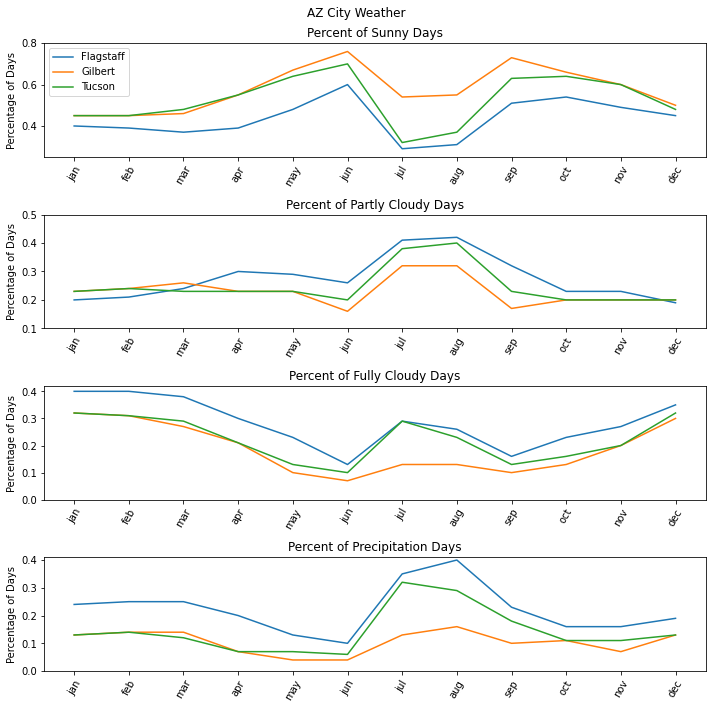

In [69]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(4,1, figsize = (10,10))
# handles, labels = axs.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
# sunny
axs[0].plot(flagstaff_weather[flagstaff_weather.columns[0]],flagstaff_weather[flagstaff_weather.columns[1]],label = 'Flagstaff')
axs[0].plot(gilbert_weather[gilbert_weather.columns[0]],gilbert_weather[gilbert_weather.columns[1]],label = 'Gilbert')
axs[0].plot(tucson_weather[tucson_weather.columns[0]],tucson_weather[tucson_weather.columns[1]],label = 'Tucson')
axs[0].set_title('Percent of Sunny Days')
axs[0].legend(loc='upper left')
axs[0].set_xticklabels(months, rotation=60)
axs[0].set_ylabel('Percentage of Days')
axs[0].set_ylim(.25,.8)
# part_cl
axs[1].plot(flagstaff_weather[flagstaff_weather.columns[0]],flagstaff_weather[flagstaff_weather.columns[2]],label = 'Flagstaff')
axs[1].plot(gilbert_weather[gilbert_weather.columns[0]],gilbert_weather[gilbert_weather.columns[2]],label = 'Gilbert')
axs[1].plot(tucson_weather[tucson_weather.columns[0]],tucson_weather[tucson_weather.columns[2]],label = 'Tucson')
axs[1].set_title('Percent of Partly Cloudy Days')
axs[1].set_xticklabels(months, rotation=60)
axs[1].set_ylabel('Percentage of Days')
axs[1].set_ylim(.1,.5)

# full_cl
axs[2].plot(flagstaff_weather[flagstaff_weather.columns[0]],flagstaff_weather[flagstaff_weather.columns[3]],label = 'Flagstaff')
axs[2].plot(gilbert_weather[gilbert_weather.columns[0]],gilbert_weather[gilbert_weather.columns[3]],label = 'Gilbert')
axs[2].plot(tucson_weather[tucson_weather.columns[0]],tucson_weather[tucson_weather.columns[3]],label = 'Tucson')
axs[2].set_title('Percent of Fully Cloudy Days')
axs[2].set_xticklabels(months, rotation=60)
axs[2].set_ylabel('Percentage of Days')
axs[2].set_ylim(0,.42)
# precip
axs[3].plot(flagstaff_weather[flagstaff_weather.columns[0]],flagstaff_weather[flagstaff_weather.columns[4]],label = 'Flagstaff')
axs[3].plot(gilbert_weather[gilbert_weather.columns[0]],gilbert_weather[gilbert_weather.columns[4]],label = 'Gilbert')
axs[3].plot(tucson_weather[tucson_weather.columns[0]],tucson_weather[tucson_weather.columns[4]],label = 'Tucson')
axs[3].set_title('Percent of Precipitation Days')
axs[3].set_xticklabels(months, rotation=60)
axs[3].set_ylabel('Percentage of Days')
axs[3].set_ylim(0,.41)

fig.suptitle('AZ City Weather')
fig.tight_layout()

The next set of plots I decided to create where bar plots that show the 4 columns for each city. I think in this form it's easier to see how the percentages for each weather category compare to one another side by side. I decided to use the bar plot format insetad of the line plot because the way that the data changes made it a little bit confusing to follow the 4 different lines. The bars also make it easy to see which weather category is most prevalent for each month. 

From this plot we can quickly see that 7 of the months are dominated by sunny days with 3 more of the months consisting of mostly sunny and fully cloudy days. Also we can see the 2 months that have a low percentage of sunny days and, like we saw in the first plots, it's during monsoon season.

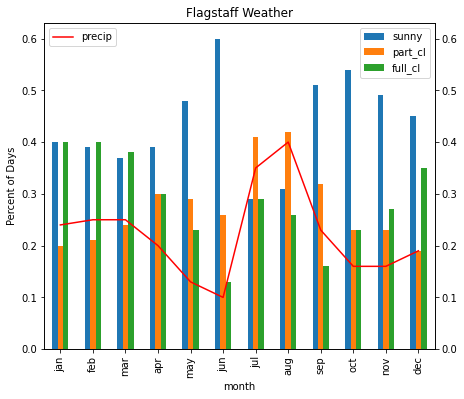

In [118]:
flagstaff_weather.plot(x="month", y=["sunny",'part_cl','full_cl'], kind="bar", 
                       figsize=(7, 6),title = 'Flagstaff Weather', ylabel = 'Percent of Days')
axes2 = plt.twinx()
axes2.plot(flagstaff_weather['precip'], color = 'red',label='precip')
axes2.set_ylim(0, .63)
axes2.legend(loc='upper left')

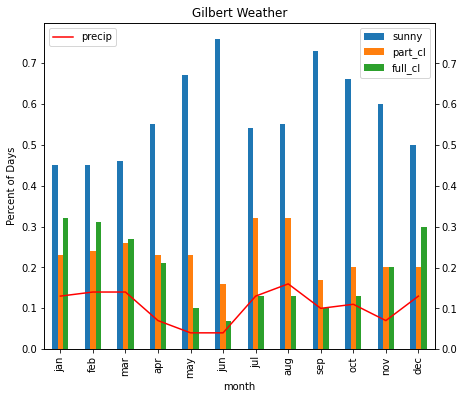

In [135]:
gilbert_weather.plot(x="month", y=["sunny",'part_cl','full_cl'], kind="bar", 
                     figsize=(7, 6),title = 'Gilbert Weather', ylabel = 'Percent of Days')
axes = plt.twinx()
axes.plot(gilbert_weather['month'], gilbert_weather['precip'],color = 'red',label='precip')
axes.set_ylim(0, .799)
axes.legend(loc='upper left')

In [120]:
axes2.plot(tucson_weather['precip'], color = 'red',label='precip')

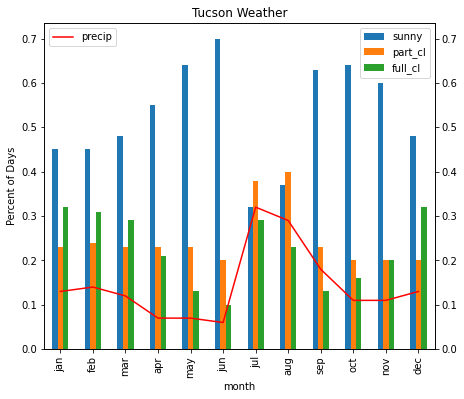

In [140]:
tucson_weather.plot(x="month", y=["sunny",'part_cl','full_cl'], kind="bar", 
                    figsize=(7,6), title = 'Tucson Weather', ylabel = 'Percent of Days')
axes = plt.twinx()
axes.plot(tucson_weather['month'], tucson_weather['precip'],color = 'red',label='precip')
axes.set_ylim(0, .735)
axes.legend(loc='upper left')

I created a SQL database called "DS224_Final.db" where I created 3 separate empty tables, one for each of the 3 cities. I then iterated over the 3 dataframes that were created when I split the orginal pandas dataframe and inserted the values into the empty SQL tables.

# SQL Database

In [20]:
conn = sqlite3.connect('DS224_Final.db') # create a connecetion to DS224_Final.db

In [21]:
cur = conn.cursor()

In [22]:
# creating the first df in SQL for flagstaff
cmd = '''CREATE TABLE IF NOT EXISTS
flagstaff_weather(
    month TEXT PRIMARY KEY,
    sunny FLOAT,
    part_cl FLOAT,
    full_cl FLOAT,
    precip FLOAT,
    city TEXT)
'''

cmd2 = '''CREATE TABLE IF NOT EXISTS
gilbert_weather(
    month TEXT PRIMARY KEY,
    sunny FLOAT,
    part_cl FLOAT,
    full_cl FLOAT,
    precip FLOAT,
    city TEXT)
'''

cmd3 = '''CREATE TABLE IF NOT EXISTS
tucson_weather(
    month TEXT PRIMARY KEY,
    sunny FLOAT,
    part_cl FLOAT,
    full_cl FLOAT,
    precip FLOAT,
    city TEXT)
'''

cur.execute(cmd)
cur.execute(cmd2)
cur.execute(cmd3)

In [45]:
for index, row in df_split[0].iterrows():
    cur.execute(f'''INSERT INTO flagstaff_weather VALUES (?,?,?,?,?,?)''',(
    row['month'],
    row['sunny'],
    row['part_cl'],
    row['full_cl'],
    row['precip'],
    row['city']
    ))
conn.commit()

for index, row in df_split[1].iterrows():
    cur.execute(f'''INSERT INTO gilbert_weather VALUES (?,?,?,?,?,?)''',(
    row['month'],
    row['sunny'],
    row['part_cl'],
    row['full_cl'],
    row['precip'],
    row['city']
    ))
conn.commit()

for index, row in df_split[2].iterrows():
    cur.execute(f'''INSERT INTO tucson_weather VALUES (?,?,?,?,?,?)''',(
    row['month'],
    row['sunny'],
    row['part_cl'],
    row['full_cl'],
    row['precip'],
    row['city']
    ))
conn.commit()

In [28]:
# example of SQL table
pd.read_sql_query('''SELECT * FROM tucson_weather''', conn)

,month,sunny,part_cl,full_cl,precip,city
0,jan,0.45,0.23,0.32,0.13,Tucson
1,feb,0.45,0.24,0.31,0.14,Tucson
2,mar,0.48,0.23,0.29,0.12,Tucson
3,apr,0.55,0.23,0.21,0.07,Tucson
4,may,0.64,0.23,0.13,0.07,Tucson
5,jun,0.70,0.20,0.10,0.06,Tucson
6,jul,0.32,0.38,0.29,0.32,Tucson
7,aug,0.37,0.40,0.23,0.29,Tucson
8,sep,0.63,0.23,0.13,0.18,Tucson
9,oct,0.64,0.20,0.16,0.11,Tucson


In [43]:
# Joining the tables

cmd4 = '''
SELECT * FROM flagstaff_weather
JOIN gilbert_weather
JOIN tucson_weather 
  '''
cur.execute(cmd4)

result = cur.fetchall()
data = []
for row in result:
    data.append(row)